In [1]:
import numpy as np
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt

In [2]:
class StandardScaler:
    def __init__(self):
        self.mean_ = None
        self.scale_ = None
        
    def fit(self, X: np.ndarray) -> 'StandardScaler':
        """Compute the mean and standard deviation of the input data."""
        self.mean_ = np.mean(X, axis=0)
        self.scale_ = np.std(X, axis=0, ddof=1)
        self.scale_ = np.where(self.scale_ == 0, 1.0, self.scale_)
        return self
        
    def transform(self, X: np.ndarray) -> np.ndarray:
        """Standardize the input data using pre-computed mean and std."""
        return (X - self.mean_) / self.scale_
        
    def fit_transform(self, X: np.ndarray) -> np.ndarray:
        """Fit to data, then transform it."""
        return self.fit(X).transform(X)

In [5]:
class TSNE:
    def __init__(self, n_components=2, perplexity=30.0, learning_rate=200.0, n_iter=1000, random_state=None):
        self.n_components = n_components
        self.perplexity = perplexity
        self.learning_rate = learning_rate
        self.n_iter = n_iter
        self.random_state = random_state

    def _compute_pairwise_distances(self, X):
        n_samples = X.shape[0]
        sum_X = np.sum(np.square(X), axis=1)
        sum_X = sum_X.reshape(-1, 1)
        distances = sum_X + sum_X.T - 2 * np.dot(X, X.T)
        distances = np.maximum(distances, 0)
        distances = np.sqrt(distances)
        np.fill_diagonal(distances, 0.0)
        return distances

    def _compute_joint_probabilities(self, distances):
        n_samples = distances.shape[0]
        P = np.zeros((n_samples, n_samples))
        target = np.log(self.perplexity)
        
        for i in range(n_samples):
            distances_i = distances[i].copy()
            distances_i[i] = np.inf
            
            sigma_min, sigma_max = 1e-20, 1000.0
            for _ in range(50):
                sigma = (sigma_min + sigma_max) / 2.0
                exp_distances = np.exp(-distances_i / (2 * sigma**2))
                sum_exp_distances = np.sum(exp_distances)
                
                if sum_exp_distances == 0:
                    H = 0
                else:
                    P_i = exp_distances / sum_exp_distances
                    P_i = np.maximum(P_i, 1e-12)
                    H = -np.sum(P_i * np.log2(P_i))
                
                if H > target:
                    sigma_max = sigma
                else:
                    sigma_min = sigma
            
            exp_distances = np.exp(-distances_i / (2 * sigma**2))
            sum_exp_distances = np.sum(exp_distances)
            if sum_exp_distances == 0:
                P[i] = np.zeros_like(exp_distances)
            else:
                P[i] = exp_distances / sum_exp_distances

        P = (P + P.T) / (2 * n_samples)
        P = np.maximum(P, 1e-12)
        return P

    def _compute_q_distribution(self, Y):
        distances = self._compute_pairwise_distances(Y)
        inv_distances = 1 / (1 + distances)
        np.fill_diagonal(inv_distances, 0)
        
        sum_inv_distances = np.sum(inv_distances)
        if sum_inv_distances == 0:
            Q = np.ones_like(inv_distances) / (inv_distances.size - n_samples)
            np.fill_diagonal(Q, 0)
        else:
            Q = inv_distances / sum_inv_distances
        
        Q = np.maximum(Q, 1e-12)
        return Q, inv_distances

    def fit_transform(self, X, early_exaggeration=12.0):
        if self.random_state is not None:
            np.random.seed(self.random_state)
            
        n_samples = X.shape[0]
        
        Y = np.random.randn(n_samples, self.n_components) * 0.0001
        
        X = X - np.mean(X, axis=0)
        
        distances = self._compute_pairwise_distances(X)
        P = self._compute_joint_probabilities(distances)
        
        P = P * early_exaggeration
        
        Y_previous = Y.copy()
        Y_gains = np.ones_like(Y)
        
        for iteration in range(self.n_iter):
            Q, inv_distances = self._compute_q_distribution(Y)
            
            PQ_diff = P - Q
            gradient = np.zeros_like(Y)
            for i in range(n_samples):
                diff = PQ_diff[i].reshape(-1, 1) * inv_distances[i].reshape(-1, 1) * (Y[i] - Y)
                gradient[i] = 4 * np.sum(diff, axis=0)
            
            Y_gains = (Y_gains + 0.2) * np.abs(np.sign(gradient) != np.sign(Y - Y_previous)) + \
                     Y_gains * 0.8 * np.abs(np.sign(gradient) == np.sign(Y - Y_previous))
            Y_gains = np.clip(Y_gains, 0.01, 100)
            
            Y_previous = Y.copy()
            momentum = 0.5 if iteration < 250 else 0.8
            Y = Y - self.learning_rate * Y_gains * gradient
            Y += momentum * (Y - Y_previous)
            
            Y = Y - np.mean(Y, axis=0)
            
            if iteration == 250:
                P = P / early_exaggeration
                print("Removed early exaggeration")
            
            if iteration % 100 == 0:
                cost = np.sum(P * np.log(np.maximum(P, 1e-12) / np.maximum(Q, 1e-12)))
                print(f"Iteration {iteration}: cost = {cost}")
        
        return Y

Iteration 0: cost = 78.3018584203939
Iteration 100: cost = 78.90622695689852
Iteration 200: cost = 78.76134189836598
Removed early exaggeration
Iteration 300: cost = 1.802805147524365
Iteration 400: cost = 1.3442516752124622
Iteration 500: cost = 1.2110689054662354
Iteration 600: cost = 1.144199562714141
Iteration 700: cost = 1.104544538682354
Iteration 800: cost = 1.075368932078078
Iteration 900: cost = 1.0582638728485299


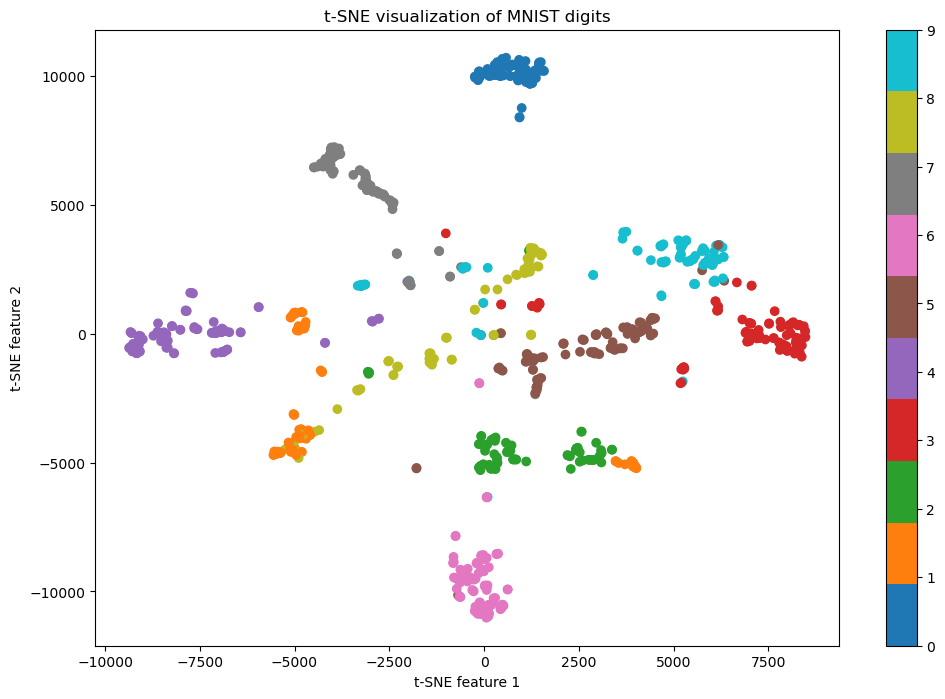

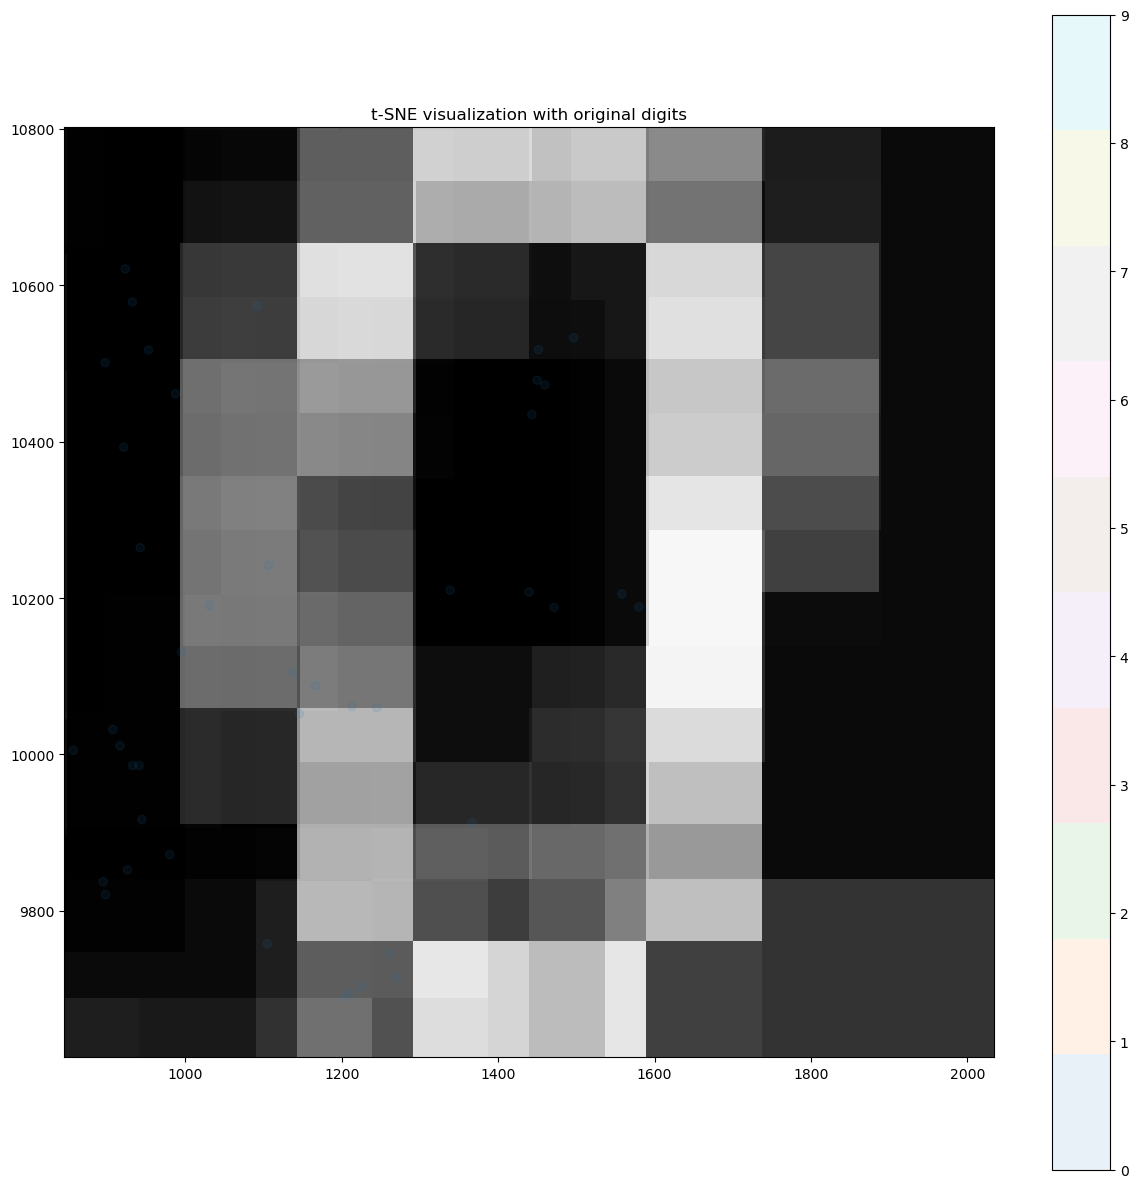

In [7]:
digits = load_digits()
X = digits.data
y = digits.target

np.random.seed(42)
idx = np.random.choice(X.shape[0], 1000, replace=False)
X_subset = X[idx]
y_subset = y[idx]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_subset)

tsne = TSNE(n_components=2, perplexity=50.0, learning_rate=200.0, n_iter=1000, random_state=42)
X_tsne = tsne.fit_transform(X_scaled, early_exaggeration=12.0)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_subset, cmap='tab10')
plt.colorbar(scatter)
plt.title('t-SNE visualization of MNIST digits')
plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')
plt.show()

def plot_digits_on_tsne(X_tsne, images, y, figsize=(15, 15), max_points=50):
    fig, ax = plt.subplots(figsize=figsize)
    
    scatter = ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='tab10', alpha=0.1)
    
    if len(images) > max_points:
        idx = np.random.choice(len(images), max_points, replace=False)
    else:
        idx = range(len(images))
    
    x_min, x_max = X_tsne[:, 0].min(), X_tsne[:, 0].max()
    y_min, y_max = X_tsne[:, 1].min(), X_tsne[:, 1].max()
    img_size = min(x_max - x_min, y_max - y_min) / 30
    
    for i in idx:
        digit_image = images[i].reshape(8, 8)
        extent = [X_tsne[i, 0] - img_size, X_tsne[i, 0] + img_size,
                 X_tsne[i, 1] - img_size, X_tsne[i, 1] + img_size]
        ax.imshow(digit_image, extent=extent, cmap='gray', alpha=0.8)
    
    plt.colorbar(scatter)
    plt.title('t-SNE visualization with original digits')
    plt.show()

plot_digits_on_tsne(X_tsne, digits.images[idx], y_subset)